In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
import requests
from pandas.io.json import json_normalize
import math
import random
import decimal
import scipy.linalg
import numpy.random as nrand

C:\Users\Edward\Documents\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import pandas as pd

def get_reddit_data(subreddit, date):
    """
    Gets top 26 frontpage titles from 'subreddit' on 'date
    :param subreddit:   ex: 'r/bitcoin'
    :param date:        in 'YYYYMMDD'
    :return titles:     a list of strings of titles
    """
    titles = []

    url = "https://web.archive.org/web/" + date + "/reddit.com/" + subreddit
    #print(url)
    driver.get(url)

    try:
        sitetable = driver.find_element_by_id("siteTable")
        posts = sitetable.find_elements_by_tag_name("div")

        for post in posts:
            if len(post.find_elements_by_class_name("title")) > 0:
                title = post.find_element_by_class_name("title").text
                titles.append(title)
        titles = set(titles)
        return titles
    except NoSuchElementException:
        return ['0'] * 26


def format_date(date):  # for way-way-back machine urls
    """
    Reformats date so that wayback machine will like it
    :param date:  in datetime64
    :return:
    """
    year = str(date.year)
    month = str(date.month)
    if len(month) < 2:
        month = "0" + month
    day = str(date.day)
    if len(day) < 2:
        day = "0" + day
    return year + month + day


# def get_reddit_dataframe(begin, fin, subreddit, writefile):
#     """
#     Makes a big dataframe indexed by a DatetimeIndex for every day from begin to fin. Values are top reddit posts, columns
#         separate titles on a given day/row.
#     :param begin:       starting date of dataframe
#     :param fin:         ending date of dataframe
#     :param subreddit:   subreddit to scrape
#     :return:            none
#     """
#     timeindex = pd.DatetimeIndex(freq='d', start=begin, end=fin)
#     data = pd.DataFrame()
#     for date in timeindex:
#         fdate = format_date(date)
#         titles = get_reddit_data(subreddit, fdate)
#         i = 1
#         for title in titles:   # probably can do this without a for loop
#             data.at[date, i] = title
#             i += 1
#         data.to_csv()


# driver = webdriver.Firefox()
# subreddit = 'r/bitcoin'
# begin = '2018-01-31'
# fin = '2018-02-13'
# #writefile = 'data/text/2018_2_14_832.csv'

# #get_reddit_dataframe(begin, fin, subreddit, writefile)

# driver.quit()

# #pd.read_csv(filepath_or_buffer='test_data/redditData.csv', infer_datetime_format=True)

In [4]:
fdate='2018-01-31'
#get_reddit_data(subreddit, fdate)

In [84]:
sent= pd.read_csv('reddit_sentiment_data.csv')
sent['Avg'] = sent.mean(axis=1)
sent['Date']=sent['Unnamed: 0']
sent=sent[['Date','Avg']]
import datetime
sent['Date']=pd.to_datetime(sent['Date'], format='%Y/%m/%d')
sent.index=sent['Date']
sent=sent[['Avg']]
prices= sent#########
prices['Weighted Price']=prices['Avg']
prices=prices[['Weighted Price']]
prices.head()

,Weighted Price
Date,
2015-02-01,0.068356
2015-02-02,0.068356
2015-02-03,0.068356
2015-02-04,0.028507
2015-02-05,0.021100


In [58]:
# Resampling to daily frequency
prices_daily = prices.resample('d').mean()

# Resampling to monthly frequency
prices_month = prices.resample('M').mean()
# Resampling to annual frequency
prices_annual = prices.resample('A-DEC').mean()

# Resampling to quarterly frequency
prices_Q = prices.resample('Q-DEC').mean()

In [59]:
b=requests.get('https://www.quandl.com/api/v3/datasets/BCHARTS/BITSTAMPUSD')
A=json_normalize(b.json())
data= A['dataset.data'].all()
df = pd.DataFrame(data)
df.columns=A['dataset.column_names'].all()
date=df['Date']
df=df[::-1]
#df.reindex(index=range(0,len(date)))
df.index= range(0,len(date))
worth=df[['Date','Weighted Price']]
import datetime
worth['Date']=pd.to_datetime(worth['Date'], format='%Y/%m/%d')
worth.index=worth['Date']
worth=worth[['Weighted Price']]
worth=worth.loc['2015-02-01':'2018-02-09']
# # N=100
# # movmean=[]
# # movstd=[]
# # for p in range(N,len(prices)):
# #     A= np.mean(prices[p-N:p])
# #     movmean.append(A)
# #     X=np.std(prices[p-N:p])
# #     movstd.append(X)
# # plt.plot(movmean,label = 'Moving Mean')
# # plt.plot(movstd, label = 'Moving Standard Deviation')


<Figure size 2160x720 with 0 Axes>

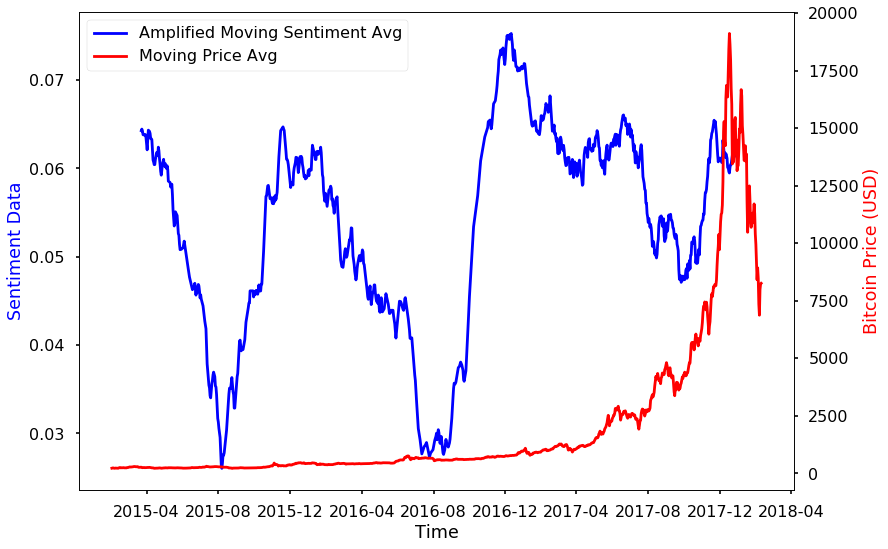

In [85]:
rolworth = worth.rolling(window=1,center=True).mean()
rolprice = prices.rolling(window=100,center=True).mean()
fig = plt.figure(figsize=[30, 10])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
a2=ax2.plot(rolworth, color='red', label='Moving Price Avg')
a1=ax1.plot(rolprice, color='blue', label='Amplified Moving Sentiment Avg')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sentiment Data', color='b')
ax2.set_ylabel('Bitcoin Price (USD)', color='r')

lns = a1+a2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

plt.show()

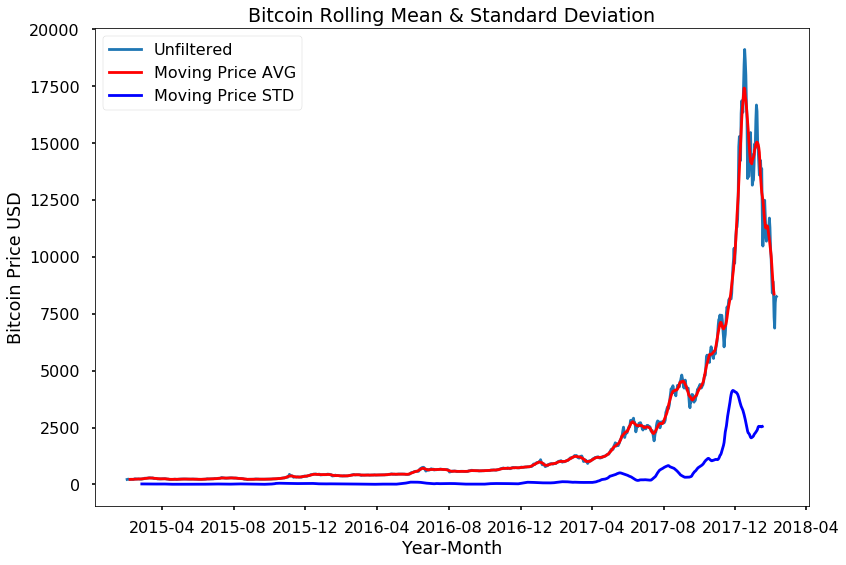

In [86]:
rolworth = worth.rolling(window=10,center=True).mean()
rolworthstd=worth.rolling(window=50,center=True).std()
plt.plot(worth,label='Unfiltered')
plt.plot(rolworth,color='red', label='Moving Price AVG')
plt.plot(rolworthstd, color='blue', label='Moving Price STD')
plt.title('Bitcoin Rolling Mean & Standard Deviation')
plt.xlabel('Year-Month')
plt.ylabel('Bitcoin Price USD')
plt.legend()
plt.show()

In [80]:
##################
prices_trains=prices[0:round(len(prices)*.87)]
prices=prices_trains
prices

,Weighted Price
Date,
2015-02-01,0.068356
2015-02-02,0.068356
2015-02-03,0.068356
2015-02-04,0.028507
2015-02-05,0.021100
2015-02-06,0.061841
2015-02-07,0.053797
2015-02-08,0.090851
2015-02-09,0.112266


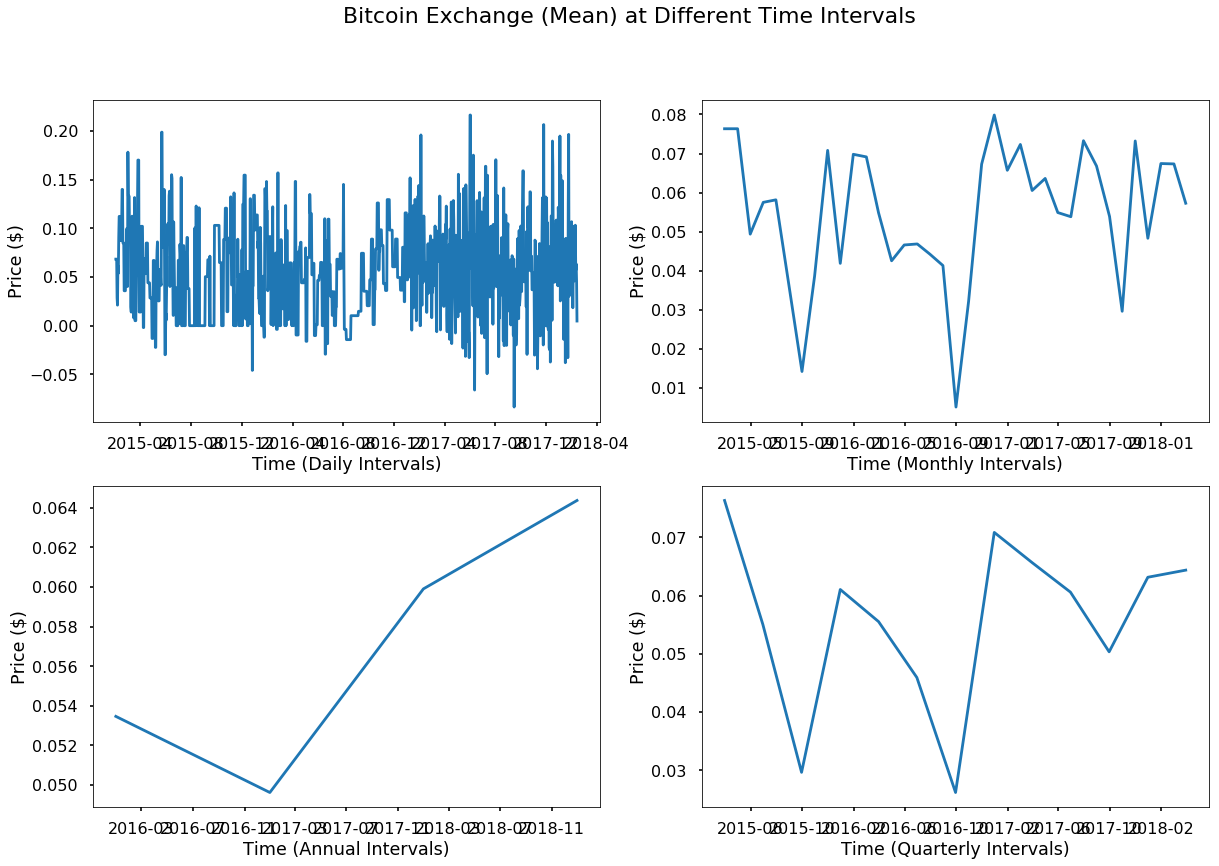

In [63]:
fig = plt.figure(figsize=[20, 13])
plt.suptitle('Bitcoin Exchange (Mean) at Different Time Intervals ', fontsize=22)

plt.subplot(221)
plt.plot(prices_daily['Weighted Price'])
plt.ylabel('Price ($)')
plt.xlabel('Time (Daily Intervals)')
plt.subplot(222)
plt.plot(prices_month['Weighted Price'])
plt.ylabel('Price ($)')
plt.xlabel('Time (Monthly Intervals)')
plt.subplot(223)
plt.plot(prices_annual['Weighted Price'])
plt.ylabel('Price ($)')
plt.xlabel('Time (Annual Intervals)')
plt.subplot(224)
plt.plot(prices_Q['Weighted Price'])
plt.ylabel('Price ($)')
plt.xlabel('Time (Quarterly Intervals)')
plt.show()

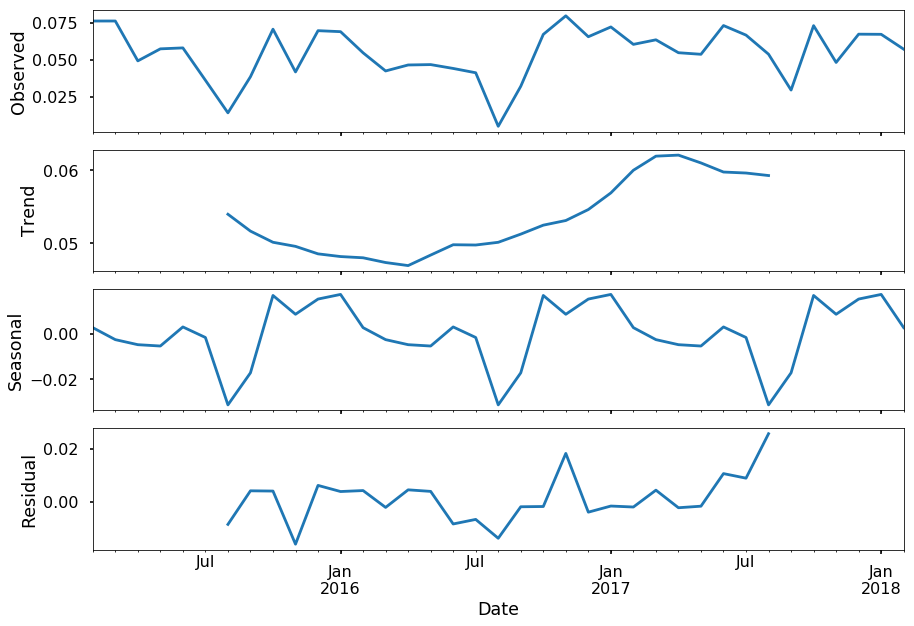

In [64]:
sm.tsa.seasonal_decompose(prices_month['Weighted Price']).plot()
plt.show()

Non-Stationary Data is data that has constantly changing mean, variance, and covariances over time. (Trends, cycles, random walks (Brownian Motion Approximation) 

Random Walk= Y[t]=Y[t-1] + E. Variance approaches infinity W/R to time with E being a distributed white noise stoichastic characteristic 

Random Walk with Drift = Y[t]=Y[t-1] + E + a, a= drift

Deterministic Trend = Y[t]= Bt + E + a: 

Dicky-Fuller: Ho = Data is Non Stationary (there is a unit root). Reject null Hypothesis when P<.05 (Stationary) 
https://stats.stackexchange.com/questions/29121/intuitive-explanation-of-unit-root

Detrending and development of a Stationary Relationship:
Y[t]- Y[t-1] = E + a

Y[t]- Bt = E + a:

BoxCox Tranforms: Creating a Normal Shape for Datum 

In [81]:
#Normalize the month price data 
prices_month['Weighted_Price_box'], lmbda = stats.boxcox(prices_month['Weighted Price'])
#Determine if this Data is Stationary 
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(prices_month['Weighted Price'])[1])
#non stationary 

Dickey–Fuller test: p=0.000857


In [82]:
## Converting to Stationary Data and then Re-examing with Stationary Test
n=12 # 12 month differentiation
#Y[t]- Y[t-1] = E (normal) + a
prices_month['prices_box_diff'] = prices_month['Weighted_Price_box'] - prices_month.Weighted_Price_box.shift(n)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(prices_month.prices_box_diff[n:])[1])
#stationary

Dickey–Fuller test: p=0.004792


In [83]:
#Regular Non Seasonal Differention
prices_month['prices_box_diff2'] = prices_month.prices_box_diff - prices_month.prices_box_diff.shift(1)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(prices_month.prices_box_diff2[13:])[1])

Dickey–Fuller test: p=0.000000


AutoCorrelation: Similarity that exists between time series vs. lagged time series 
Ie calculating the relationship between two times series, however these are the same time series where one is lagged 

HOW MUCH DOES PAST DATA IMPACT FUTURE DATA (Lagged Correlation) - Stock momentum 

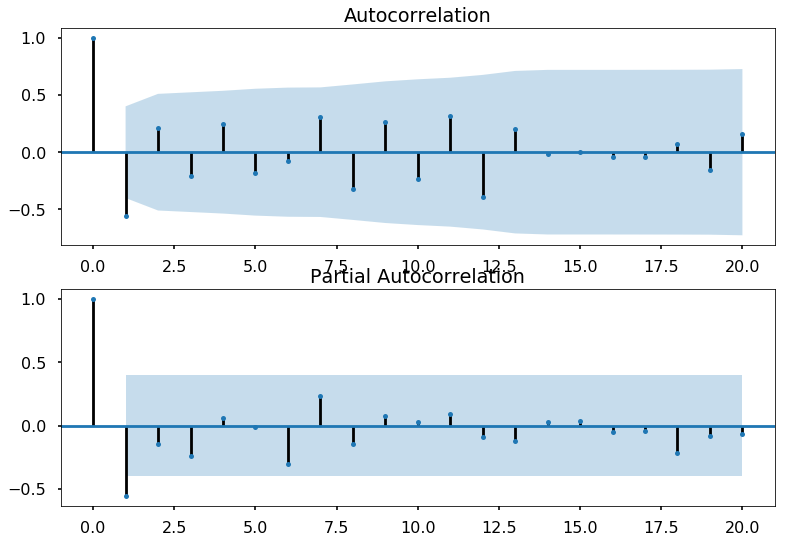

In [68]:

ax = plt.subplot(211)

#perform test on normalized and differentiated (stationary) data
#AutoCorrelation
sm.graphics.tsa.plot_acf(prices_month.prices_box_diff2[13:].values.squeeze(), lags=20, ax=ax)

ax = plt.subplot(212)
#Partial AutoCorrelation 
sm.graphics.tsa.plot_pacf(prices_month.prices_box_diff2[13:].values.squeeze(), lags=20, ax=ax)



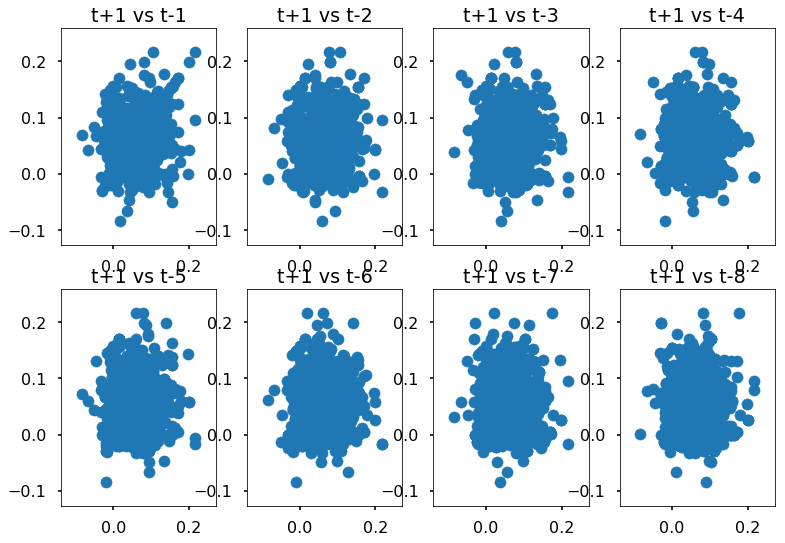

<Figure size 2160x720 with 0 Axes>

In [69]:
fig = plt.figure(figsize=[30, 10])
from pandas import concat
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
values=prices['Weighted Price']
lags = 8
values = prices['Weighted Price'] #collected prices values 
columns = [values] #create list 
for i in range(1,(lags + 1)): #run for loop for 1 to 8 lag iterations/examinations
	columns.append(values.shift(i)) #shift the data according to each lag then add to the set
dataframe = concat(columns, axis=1) #concactinate all these columns 
columns = ['t+1']
for i in range(1,(lags + 1)):
 	columns.append('t-' + str(i)) #creats columns title t-(lag#)
dataframe.columns = columns #set as columns
pyplot.figure(1)
for i in range(1,(lags + 1)): # plot data
 	ax = pyplot.subplot(240 + i)
 	ax.set_title('t+1 vs t-' + str(i))
 	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)

pyplot.show()


- ARIMA:Auto Regressive Integrated Moving Average 
- AutoRegressive- using past variable of time to predict future (lags of stationarized series)
- Integrated- Time series is differenced to be stationarized
- Moving Average- lags of forecast error  
- A stationary series has no trend, its variations around its mean have a constant amplitude, and it wiggles in a consistent fashion 
- Autocorrelations are the same for stationary data
- The ARIMA forecasting equation for a stationary time series is a linear (i.e., regression-type) equation in which the predictors consist of lags of the dependent variable and/or lags of the forecast errors
- PREDICTED Y= weight of previous values + weight of previous errors

Required Prior Knowledge:

-Box-Jenkins Model 



ARIMA(P,D,Q) model:
- used on random walk autoregressive models, exponential smoothing 
P= # of autoregressive terms (lag observations) 
D= # of nonseasonal differences needed for stationarity: how much differencing is occuring 
Q= # of lagged forecast errors [moving average window]

1. Identification: Of all the data, select a portion of the Model the best summarizes the data
    Is the data stationary, and how many differences are needed to make it stationary
    FOR Time Series: x3 x2 x1 
    
    ACF= True Corr of  x2 & x1 = (corr(x3,x2)) + PACF(X2,x1)
    PACF(X2,x1) = ACF- (corr(x3,x2))
    ACF- Corr(Observation, Lagged Observation)
    PACF- Corr(Observation, Lagged Observation) 
    
    Values that cross the 95% interval are significant 
    
    AR- if ACF has trail off, hard cutoff PACF (p) 
    MA- if PACF has trail off, hard cutoff ACF (q)

Stationary= statistical properties are all constant over time. 
    Autocorrleations (prior deviations from mean) are constant
    

    
    
    



In [70]:
#Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


54

In [71]:
# Model Determination 
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list: #run through each grouping of parameters (54 total combos)
    try:
        model=sm.tsa.statespace.SARIMAX(prices_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 1, 1)
wrong parameters: (0, 0, 2, 0)
wrong parameters: (0, 0, 2, 1)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 1, 2, 0)
wrong parameters: (0, 1, 2, 1)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 2, 2, 0)
wrong parameters: (0, 2, 2, 1)
wrong parameters: (1, 0, 0, 1)
wrong parameters: (1, 0, 1, 1)
wrong parameters: (1, 0, 2, 0)
wrong parameters: (1, 0, 2, 1)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 1, 1, 1)
wrong parameters: (1, 1, 2, 0)
wrong parameters: (1, 1, 2, 1)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (2, 0, 0, 1)
wrong parameters: (2, 0, 1, 1)
wrong parameters: (2, 0, 2, 0)
wrong parameters: (2, 0, 2, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong pa

In [72]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
2   (0, 1, 1, 0) -212.812096
6   (1, 0, 1, 0) -212.059678
0   (0, 0, 1, 0) -211.211003
12  (2, 0, 1, 0) -210.400839
8   (1, 1, 1, 0) -210.274080
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                   37
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 109.406
Date:                            Sun, 22 Apr 2018   AIC                           -212.812
Time:                                    01:19:24   BIC                           -207.979
Sample:                                02-28-2015   HQIC                          -211.108
                                     - 02-28-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

In [73]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))


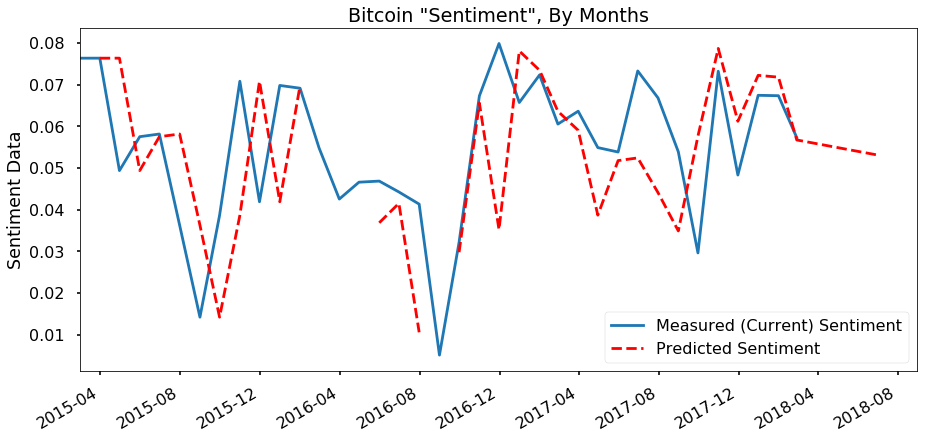

In [74]:
# Prediction
from datetime import datetime
df_month2 = prices_month[['Weighted Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 6, 30),datetime(2018,7, 30),datetime(2018,8, 30)]
future = pd.DataFrame(index=date_list, columns= prices_month.columns)

df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=1, end=1500), lmbda)
plt.figure(figsize=(15,7))
plt.plot(df_month2['Weighted Price'],label='Measured (Current) Sentiment')
df_month2.forecast.plot(color='r', ls='--', label='Predicted Sentiment')
plt.legend()
plt.title('Bitcoin "Sentiment", By Months')
plt.ylabel('Sentiment Data')

plt.show()